### Transfer Learning

Transfer learning can basically expressed as, taking the patterns (also called weights) another model has learned from another problem and using them for our own problem.

There are two main benefits to using transfer learning:

1. Can leverage an existing neural network architecture proven to work on problems similar to our own.
2. Can leverage a working neural network architecture which has already learned patterns on similar data to our own. This often results in achieving great results with less custom data.

Instead of training our own models from scratch on our own datasets, we can take the patterns a model has learned from datasets such as ImageNet (millions of images of different objects) and use them as the foundation of our own. Doing this often leads to getting great results with less data.

Transfer learning often allows you to get great results with less data.

### Check the GPU model

In [1]:
!nvidia-smi

Wed Apr 19 13:04:14 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Tensorflow Hub

For many of the problems you'll want to use deep learning for, chances are, a working model already exists in Tensorflow Hub. TensorFlow Hub is a repository for existing model components. It makes it so you can import and use a fully trained model with as little as a URL.






In [2]:
import zipfile

! wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2023-04-19 13:04:14--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.12.128, 172.217.194.128, 172.253.118.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.12.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  19.1MB/s    in 9.5s    

2023-04-19 13:04:24 (16.9 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:
import os

for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")

There are 2 directories and 0 images in '10_food_classes_10_percent'
There are 10 directories and 0 images in '10_food_classes_10_percent/test'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger

Notice how each of the training directories has 75 images. (Really low value for training a model)

### Prepare the Data

Creating Data Loaders

In [4]:
IMG_SIZE = (224, 224)
INPUT_SHAPE = IMG_SIZE + (3,)
BATCH_SIZE = 32
NUM_EPOCHS = 5

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_data_gen = ImageDataGenerator(rescale=1/255.)
test_data_gen = ImageDataGenerator(rescale=1/255.)

print("Training images: ")
train_data_10_percent = train_data_gen.flow_from_directory(train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical')

print("Test images: ")
test_data = test_data_gen.flow_from_directory(test_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical')

Training images: 
Found 750 images belonging to 10 classes.
Test images: 
Found 2500 images belonging to 10 classes.


### Setting up Callbacks

Callbacks are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks include:

* **TensorBoard** - Helpful to compare the results (log of the performance) of different models on your data. - tf.keras.callbacks.TensorBoard()
* **Model checkpointing** - save your model as it trains so you can stop training if needed and come back to continue off where you left. Helpful if training takes a long time and can't be done in one sitting.
* **Early stopping** - leave your model training for an arbitrary amount of time and have it stop training automatically when it ceases to improve. Once the loss's found no longer decreasing, model.stop_training is marked True and the training terminates.

By default, logs are recorded every epoch using the update_freq='epoch' parameter. This is a good default since tracking model performance too often can slow down model training.

### Create Tensorboard callback

Use functions to create because we need to create for each trained model

In [14]:
import datetime
import tensorflow as tf

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

### Creating models using Tensorflow Hub

https://tfhub.dev/

Majority of our model's layers are going to come from TensorFlow Hub.

We're going to use two models from TensorFlow Hub:
1. ResNetV2 - a state of the art computer vision model architecture from 2016. - https://arxiv.org/pdf/1603.05027.pdf
2. EfficientNet - a state of the art computer vision architecture from 2019. - https://arxiv.org/pdf/1905.11946.pdf

Keywords for Tensorflow Hub search "image feature vector", "image classification"

* Select the **Architecture** tab on TensorFlow Hub and you'll see a dropdown menu of architecture names appear. The rule of thumb here is generally, names with larger numbers means better performing models. For example, EfficientNetB4 performs better than **EfficientNetB0**. However, the tradeoff with larger numbers can mean they take longer to compute.

* Clicking the one titled **"efficientnet/b0/feature-vector"** brings us to a page with a button that says "Copy URL". That URL is what we can use to harness the power of EfficientNetB0.

* Copy the URL of the model - 

EfficientNet - 
https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1

ResNetV2 - 
https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5

#### Feature extraction transfer learning
Let say the pretrained model you were using had 236 different layers (EfficientNetB0 has 236 layers), but the top layer outputs 1000 classes because it was pretrained on ImageNet. To adjust this to your own problem, you might remove the original activation layer and replace it with your own but with the right number of output classes. The important part here is that **only the top few layers become trainable, the rest remain frozen**. This kind of transfer learning (feature vector-extraction) is very helpful when your data is similar to the data a model has been pretrained on.

#### Fine-tuning Transfer Learning
When you take the underlying patterns (called weights) of a pretrained model and adjust (fine-tune) them to your own problem. This usually means training some, many or all of the layers in the pretrained model. This is useful when you've got a large dataset (e.g. 100+ images per class) where your data is slightly different to the data the original model was trained on.

A common workflow is to "freeze" all of the learned patterns in the bottom layers of a pretrained model so they're untrainable. And then train the top 2-3 layers of so the pretrained model can adjust its outputs to your custom data (feature extraction).

![](https://camo.githubusercontent.com/fe18c60e0d7acad76998ae1ca52f3e45f263c79a916c2d7a4308b42b456d9038/68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f6d7264626f75726b652f74656e736f72666c6f772d646565702d6c6561726e696e672f6d61696e2f696d616765732f30342d646966666572656e742d6b696e64732d6f662d7472616e736665722d6c6561726e696e672e706e67)



In [7]:
import tensorflow_hub as hub
from tensorflow.keras import layers

# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"

# Original: EfficientNetB0 feature vector (version 1)
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"


When we use them in our model, the model will automatically be downloaded for us to use.

To do this, we can use the **KerasLayer()** model inside the TensorFlow hub library.

Since we're going to be comparing two models, to save ourselves code, we'll create a function **create_model()**. This function will take a model's TensorFlow Hub URL, instatiate a Keras Sequential model with the appropriate number of output layers and return the model.

In [8]:
# Takes a TensorFlow Hub URL and creates a Keras Sequential model with it
def create_model(model_hub_url, num_classes=10):
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_hub_url, trainable=False, name='feature_extraction_layer', input_shape=INPUT_SHAPE)

  model = tf.keras.Sequential([
      feature_extractor_layer,
      layers.Dense(num_classes, activation='softmax', name='output_layer')
  ])

  return model

### Create and Compile the ResNet model

In [9]:
# Create ResNet model
resnet_model = create_model(resnet_url, num_classes=train_data_10_percent.num_classes)

# Compile the model
resnet_model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

![](https://camo.githubusercontent.com/85694b6f1b9cd4df5dd8cc256d9902f40b00b0dbe16f045872510d4205c2d735/68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f6d7264626f75726b652f74656e736f72666c6f772d646565702d6c6561726e696e672f6d61696e2f696d616765732f30342d7265736e65742d666561747572652d657874726163746f722e706e67)


### Fit the ResNet model with Tensorboard callback for training log

In [15]:
# Fit the model
resnet_history = resnet_model.fit(train_data_10_percent, 
                                  epochs=NUM_EPOCHS, 
                                  validation_data=test_data, 
                                  validation_steps=len(test_data), 
                                  callbacks=[create_tensorboard_callback(dir_name='tensorflow_hub', experiment_name='resnet50V2')])

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20230419-131131
Epoch 1/5
24/24 [==============================] - 25s 1s/step - loss: 0.3032 - accuracy: 0.9427 - val_loss: 0.6553 - val_accuracy: 0.7904
Epoch 2/5
24/24 [==============================] - 24s 1s/step - loss: 0.2573 - accuracy: 0.9547 - val_loss: 0.6370 - val_accuracy: 0.7908
Epoch 3/5
24/24 [==============================] - 19s 796ms/step - loss: 0.2154 - accuracy: 0.9667 - val_loss: 0.6306 - val_accuracy: 0.7896
Epoch 4/5
24/24 [==============================] - 18s 752ms/step - loss: 0.1815 - accuracy: 0.9827 - val_loss: 0.6339 - val_accuracy: 0.7936
Epoch 5/5
24/24 [==============================] - 21s 904ms/step - loss: 0.1599 - accuracy: 0.9893 - val_loss: 0.6262 - val_accuracy: 0.7928


In [11]:
import matplotlib.pyplot as plt

# Plot the validation and training data separately
def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()
  plt.show()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();
  plt.show()

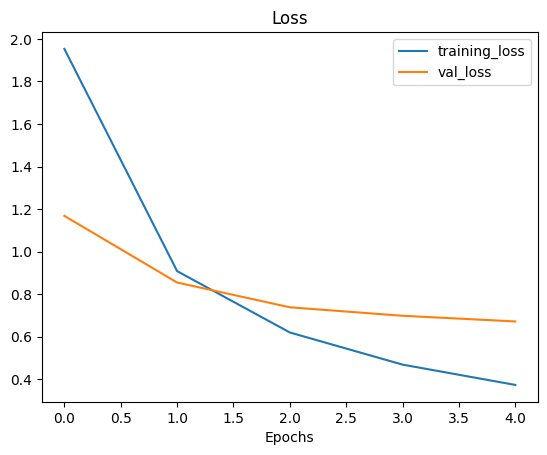

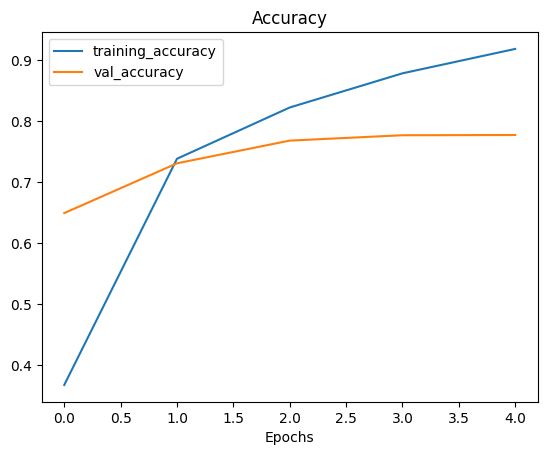

In [12]:
plot_loss_curves(resnet_history)

In [13]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


The feature extraction layer has 23,564,800 parameters which are prelearned patterns the model has already learned on the ImageNet dataset. Since we set trainable=False, these patterns remain frozen (non-trainable) during training. This means during training the model updates the 20,490 parameters in the output layer to suit our dataset.

### Create, Compile and Fit the EfficientNet model

In [18]:
# Create EfficientNet Model
efficient_model = create_model(model_hub_url=efficientnet_url, num_classes=10)

# Compile the model
efficient_model.compile(loss='categorical_crossentropy',
                        optimizer=tf.keras.optimizers.Adam(),
                        metrics=['accuracy'])

efficientnet_history = efficient_model.fit(train_data_10_percent, epochs=5, steps_per_epoch=len(train_data_10_percent),
                    validation_data=test_data, validation_steps=len(test_data),
                    callbacks=[create_tensorboard_callback(dir_name='tensorflow_hub', experiment_name='efficientnetB0')])

Saving TensorBoard log files to: tensorflow_hub/efficientnetB0/20230419-131441
Epoch 1/5
24/24 [==============================] - 30s 838ms/step - loss: 1.7955 - accuracy: 0.4827 - val_loss: 1.2714 - val_accuracy: 0.7328
Epoch 2/5
24/24 [==============================] - 18s 756ms/step - loss: 1.0490 - accuracy: 0.7653 - val_loss: 0.8599 - val_accuracy: 0.8124
Epoch 3/5
24/24 [==============================] - 17s 726ms/step - loss: 0.7487 - accuracy: 0.8267 - val_loss: 0.6959 - val_accuracy: 0.8376
Epoch 4/5
24/24 [==============================] - 17s 746ms/step - loss: 0.6036 - accuracy: 0.8680 - val_loss: 0.6074 - val_accuracy: 0.8520
Epoch 5/5
24/24 [==============================] - 16s 706ms/step - loss: 0.5093 - accuracy: 0.8893 - val_loss: 0.5540 - val_accuracy: 0.8620


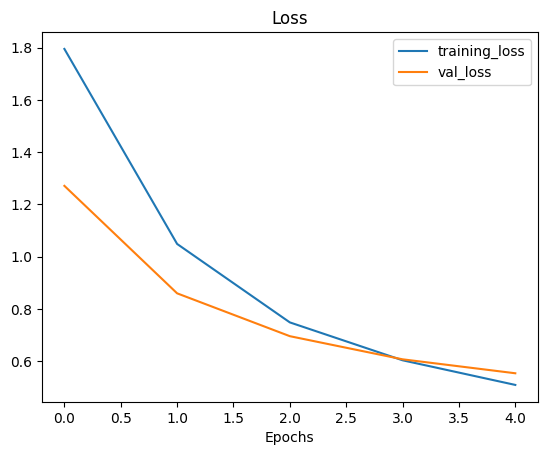

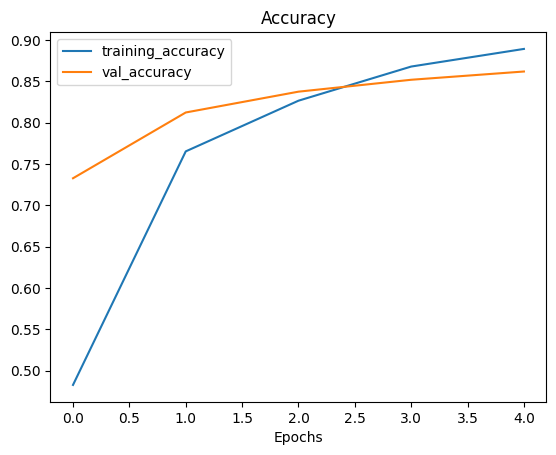

In [19]:
plot_loss_curves(efficientnet_history)

In [20]:
efficient_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


### Comparing models using TensorBoard

TensorBoard.dev: https://tensorboard.dev/

In continuation of this notebook:
* Uploading experiments to TensorBoard
* Listing experiments you have saved to TensorBoard
* Deleting experiments from TensorBoard

### Reference

https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/04_transfer_learning_in_tensorflow_part_1_feature_extraction.ipynb